Inequality constraints incompatible
[-10.27692869  40.69082642 -26.4587906  -44.11641091  61.78576291
 -19.53593137  88.08568605 -40.95744624   1.92978324 -66.20621569
  21.00443644 -78.06724646  33.61609397  30.44662836  22.85903542
   0.47530899  -5.12560935  18.76965456 -26.26878831  12.39090453
  -0.14694209   0.11170795   0.3300777    0.69467815  -0.10271255]
 message: Inequality constraints incompatible
 success: False
  status: 4
     fun: 863013.8702226687
       x: [-1.028e+01  4.069e+01 ...  6.947e-01 -1.027e-01]
     nit: 21
     jac: [ 4.769e+03  2.092e+03 ...  2.448e+03  2.036e+03]
    nfev: 649
    njev: 20


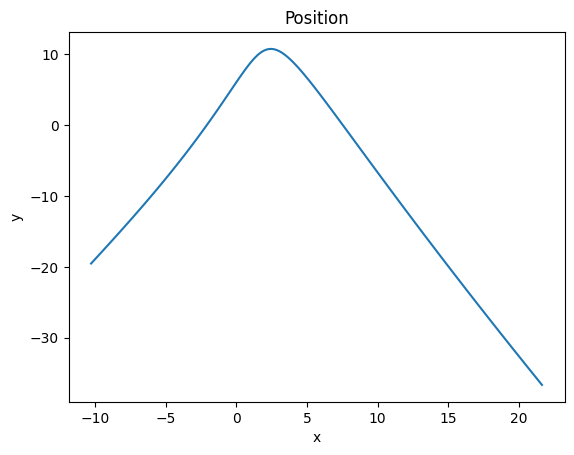

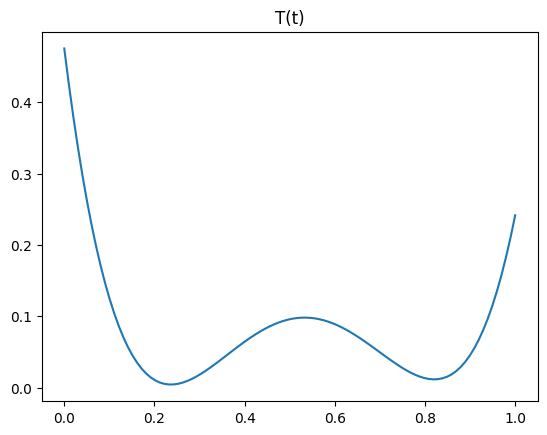

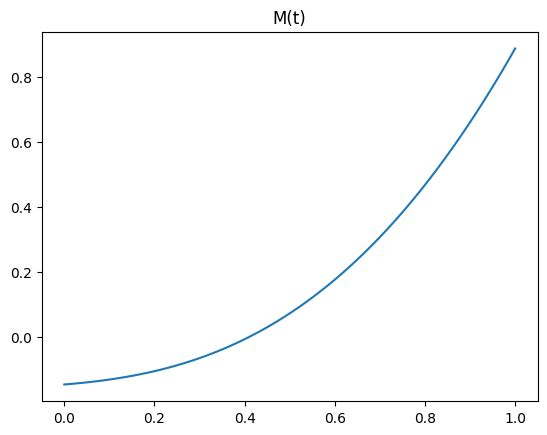

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

def generate_polynomial_basis(t, degree):
    basis_functions = []
    for d in range(degree + 1):
        basis_functions.append(t**d)
    basis_functions = np.array(basis_functions).T
    derivative_basis_functions = np.zeros_like(basis_functions)
    for d in range(degree):
        derivative_basis_functions[:, d] = (d + 1) * basis_functions[:, d + 1]
    second_derivative_basis_functions = np.zeros_like(basis_functions)
    for d in range(degree - 1):
        second_derivative_basis_functions[:, d] = (d + 1) * derivative_basis_functions[:, d + 1]
    return basis_functions, derivative_basis_functions, second_derivative_basis_functions
t = np.linspace(0, 1, 100)  # Time vector
def circle_constraint_1(variables):
    x, y = variables[0],variables[2]  # Get final x, y from final conditions
    x1, y1 = 0.2, 0.5  # Center of the circle
    r = 0.2  # Radius of the circle
    return (x - x1)**2 + (y - y1)**2 - r**2  # Ensure the point is outside the circle
def circle_constraint_2(variables):
    x, y = variables[0],variables[2]  # Get final x, y from final conditions
    x1, y1 = 0.3, 0.8  # Center of the circle
    r = 0.2  # Radius of the circle
    return (x - x1)**2 + (y - y1)**2 - r**2  # Ensure the point is outside the circle
t = np.linspace(0, 1, 100)  # Time vector
degree = 4  # Degree of the polynomial
basis_functions, derivative_basis_functions, second_derivative_basis_functions = generate_polynomial_basis(t, degree)
alpha_x,alpha_y,alpha_theta,alpha_T,alpha_M = np.zeros(5),np.zeros(5),np.zeros(5),np.zeros(5),np.zeros(5)
alpha_guess = np.hstack((alpha_x,alpha_y,alpha_theta,alpha_T,alpha_M))
initial_conditions = np.array([0.0,0.0,0.0,0.0,0.0]) # x,y,theta,T,M
final_conditions = np.array([1.0,1.0,0.0,0.9,0.0]) # x,y,theta,T,M
def Error(alpha):
  mass = 1
  inertia_z = 1
  alpha_x_slice = alpha[:5]
  alpha_y_slice = alpha[5:2*5]
  alpha_theta_slice = alpha[2*5:3*5]
  alpha_T = alpha[3*5:4*5]
  alpha_M = alpha[4*5:25]

  error_x = np.sum((mass * second_derivative_basis_functions @ alpha_x_slice - \
                    basis_functions @ alpha_T * np.cos(basis_functions @ alpha_theta_slice))**2)
  error_y = np.sum((mass * second_derivative_basis_functions @ alpha_y_slice - \
                    basis_functions @ alpha_T * np.sin(basis_functions @ alpha_theta_slice))**2)
  error_M = np.sum((inertia_z * second_derivative_basis_functions @ alpha_theta_slice - basis_functions @ alpha_M)**2)

  error_IC = np.sum((basis_functions @ alpha_x_slice - initial_conditions[0])**2 + \
                    (basis_functions @ alpha_y_slice - initial_conditions[1])**2 + \
                    (basis_functions @ alpha_theta_slice - initial_conditions[2])**2 + \
                    (basis_functions @ alpha_T - initial_conditions[3])**2 + \
                    (basis_functions @ alpha_M - initial_conditions[4])**2)
  error_FC = np.sum((basis_functions @ alpha_x_slice - final_conditions[0])**2 + \
                    (basis_functions @ alpha_y_slice - final_conditions[1])**2 + \
                    (basis_functions @ alpha_theta_slice - final_conditions[2])**2 + \
                    (basis_functions @ alpha_T - final_conditions[3])**2 + \
                    (basis_functions @ alpha_M - final_conditions[4])**2)
  J = error_x + error_y + error_M + 10*error_IC + 10*error_FC
  return J
# Initial guess for alpha
constraints = ({'type': 'ineq', 'fun': lambda variables: basis_functions@variables[3*5:4*5]},  # T >= 0
               {'type': 'ineq', 'fun': lambda variables: 1 - basis_functions@variables[3*5:4*5]},  # T <= 1
               {'type': 'ineq', 'fun': lambda variables: -1 - basis_functions@variables[4*5:25]},  # M >= -1
               {'type': 'ineq', 'fun': lambda variables: basis_functions@variables[4*5:25] - 1})# , # M <= 1
               # {'type': 'ineq', 'fun': circle_constraint_1},  # Constraint to keep point outside the circle 1
               # {'type': 'ineq', 'fun': circle_constraint_2})  # Constraint to keep point outside the circle 2
# Minimize the error function
result = minimize(Error, alpha_guess, constraints=constraints,options={'maxiter':10000},method='SLSQP')
optimized_alpha = result.x
print(result.message)
print(optimized_alpha)
print(result)
plt.plot(np.dot(basis_functions,optimized_alpha[:5]),basis_functions@optimized_alpha[5:2*5])
plt.title('Position')
plt.xlabel('x')
plt.ylabel('y')
plt.show()
plt.plot(t,basis_functions@optimized_alpha[3*5:4*5])
plt.title('T(t)')
plt.show()
plt.plot(t,basis_functions@optimized_alpha[4*5:25])
plt.title('M(t)')
plt.show()

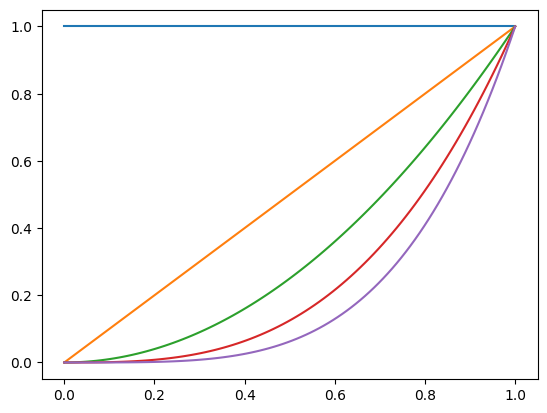

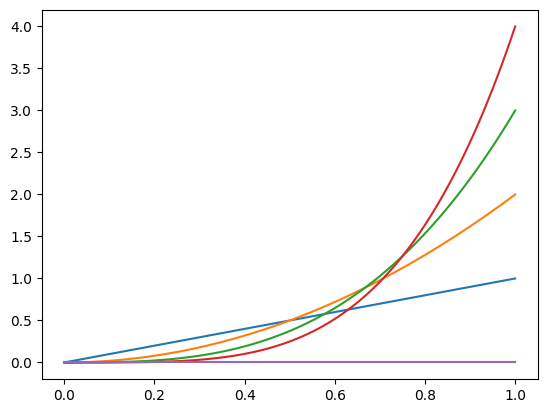

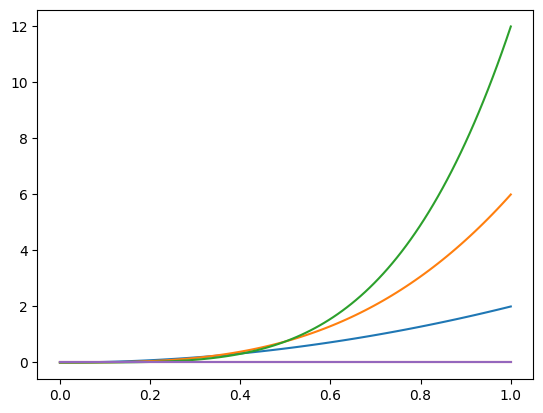

In [9]:
plt.plot(t,basis_functions[:])
plt.show()
plt.plot(t,derivative_basis_functions[:])
plt.show()
plt.plot(t,second_derivative_basis_functions[:])
plt.show()

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from tqdm.notebook import tqdm
from keras.layers import Dense
from numpy import pi

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

2024-03-04 12:44:21.178850: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-04 12:44:21.346571: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-04 12:44:21.346687: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-04 12:44:21.368852: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-04 12:44:21.431843: I tensorflow/core/platform/cpu_feature_guar

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-03-04 12:44:23.163494: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:f3:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-04 12:44:23.357006: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:f3:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-04 12:44:23.357041: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:f3:00.0/numa_node
Your kernel may have been built without NUMA support.


In [ ]:
# Design the neural network
def createTraj():
    fhat = Sequential()
    fhat.add(Dense(50, activation="sigmoid", input_dim=1))
    fhat.add(Dense(1))
    return fhat

x = createTraj()
y = createTraj()
T = createTraj()
M = createTraj()
theta = createTraj()

2024-03-04 12:44:29.452438: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:f3:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-04 12:44:29.452536: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:f3:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-04 12:44:29.452553: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:f3:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-04 12:44:29.682774: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:f3:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-04 12:44:29.682905: I external/local_xla/xla/stream_executor

In [ ]:
T0 = 0
Tf = 1
nPts = 20
T = tf.cast(tf.linspace(0,Tf,nPts),dtype=tf.float32)

def errors(t):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(t)
        X = x(t)
        Y = y(t)
    mass = 1
    inertia_z = 1
    Xd = tape.gradient(X,t)
    Xdd = tape.gradient(Xd,t)
    Yd = tape.gradient(Y,t)
    Ydd = tape.gradient(Yd,t)
    TH = theta(t)
    TH_d = tape.gradient(TH,t)
    TH_dd = tape.gradient(TH_d,t)
    Thrust  = T(t)
    Moment  = M(t)
    
    # Error in dynamics
    e_xddot = tf.reduce_sum((tf.reshape(Xdd,shape=(nPts,1)) - Thrust*tf.cos(TH)/mass)**2)
    e_yddot = tf.reduce_sum((tf.reshape(Ydd,shape=(nPts,1)) - T*tf.sin(TH)/mass)**2)
    e_thetaddot = tf.reduce_sum((tf.reshape(TH_dd,shape=(nPts,1)) - Moment/inertia_z)**2)

    # Error in initial condition
    x0 = 0; y0 = 0; th_0 = 0; x_dot_0 = 0; y_dot_0 = 0; th_dot_0 = 0;
    eIC = (X[0] - x0)**2  + (Y[0] - y0)**2  + (TH[0])**2 + Thrust[0]**2 + Moment[0]**2# start from (x0,y0) at rest and pointing east

    # Error in final condition
    xf = 1; yf = 1; th_f = 0; x_dot_f = 0; y_dot_f = 0; th_dot_0 = 0;
    eFC = (X[-1] - xf)**2 + (Y[-1] - yf)**2 + (TH[-1]-pi)**2 + Thrust[-1]**2 + Moment[-1]**2 # end at (xf,yf) at rest and pointing west 
    
    return e_xddot + e_yddot + 10*eIC + 10*eFC 

In [ ]:
run_counter = 0
while errors(T) >= 0.001:
    nIter = 400
    run_counter += 1
    if run_counter == 11:
        print('Failed to converge')
        break
    if errors(T) <= 1:
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)
    elif errors(T) <= 0.5:
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
    elif errors(T) <= 0.1:
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)
    elif errors(T) <= 0.01:
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.00001)
    else:
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.1)
    for i in tqdm(range(nIter),desc=f"Training run {run_counter}"):
        with tf.GradientTape(persistent=True) as tape_second_order:
          with tf.GradientTape(persistent=True) as tape_first_order:
            e = errors(T)
          if e <= 0.001:
            print('Finish Training')
            break
        # if i%50 == 0:    
            # print(f'iter: {i}, error: {e[0]}')
    
        # Update parameters in x
            grads = tape.gradient(e, x.trainable_variables)
            optimizer.apply_gradients(zip(grads, x.trainable_variables))

            # Update parameters in y
            grads = tape.gradient(e, y.trainable_variables)
            optimizer.apply_gradients(zip(grads, y.trainable_variables))

            # Update parameters in Thrust
            grads = tape.gradient(e, T.trainable_variables)
            optimizer.apply_gradients(zip(grads, T.trainable_variables))

            # Update parameters in Moment
            grads = tape.gradient(e, M.trainable_variables)
            optimizer.apply_gradients(zip(grads, M.trainable_variables))

            # Update parameters in th
            grads = tape.gradient(e, theta.trainable_variables)
            optimizer.apply_gradients(zip(grads, theta.trainable_variables))
      # Update parameters in x
          grads = tape.gradient(e, x.trainable_variables)
          optimizer.apply_gradients(zip(grads, x.trainable_variables))

          # Update parameters in y
          grads = tape.gradient(e, y.trainable_variables)
          optimizer.apply_gradients(zip(grads, y.trainable_variables))

          # Update parameters in Thrust
          grads = tape.gradient(e, T.trainable_variables)
          optimizer.apply_gradients(zip(grads, T.trainable_variables))

          # Update parameters in Moment
          grads = tape.gradient(e, M.trainable_variables)
          optimizer.apply_gradients(zip(grads, M.trainable_variables))

          # Update parameters in th
          grads = tape.gradient(e, theta.trainable_variables)
          optimizer.apply_gradients(zip(grads, theta.trainable_variables))
    print(f"Last error: {round(float(errors(T)[0]),4)}")

TypeError: Argument `target` should be a list or nested structure of Tensors, Variables or CompositeTensors to be differentiated, but received None.